In [45]:
from io import BytesIO  
import requests
import numpy as np
import json

#
# オブジェクトストレージ認証
#
def ObjectStorage_Authentication(credentials):
    # 認証
    os_auth_url = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    os_cred = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': credentials['username'],'domain': {'id': credentials['domainId']},
            'password': credentials['password']}}}}}
    os_header = {'Content-Type': 'application/json'}
    resp = requests.post(url=os_auth_url, data=json.dumps(os_cred), headers=os_header)
    
    # 認証エラー処理
    if resp.status_code != 201:
        return False, resp.status_code, None, None
    
    # オブジェクト・ストレージのURLとトークンを返却
    body = resp.json()
    for e1 in body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                if(e2['interface']=='public'and e2['region']=='dallas'):
                    return True, resp.status_code, e2['url'], resp.headers['x-subject-token'] 
    

#
# Numpy の配列データをCSV形式で、オブジェクトストレージへ書き込み
#
def Write_CSV_to_ObjectStorage(credentials, npdata, label, container, fileName):  

    csvData = ""
    # Label データをCSVの先頭行へ書き込み
    c = 0
    for col in label:
        if c > 0:
            csvData = csvData + ','
        csvData = csvData + col
        c = c + 1
    csvData = csvData + "\n"
    
    # Numpy配列データを CSV形式テキストデータへ変換
    rows, cols = np.shape(npdata)
    for row in a:
        c = 0
        for col in row:
            if c > 0:
                csvData = csvData + ','
            csvData = csvData + str(col)
            c = c + 1
        csvData = csvData + "\n"
    
    # オブジェクト・ストレージ認証
    rslt, status, os_endpoint, os_token = ObjectStorage_Authentication(credentials)
    if rslt == False:
        return rslt, status
    
    # オブジェクト・ストレージ PUT データ書込み
    os_url = ''.join([os_endpoint,'/', container, '/', fileName])
    header = {'X-Auth-Token': os_token, 'accept': 'application/json'}
    resp = requests.put(url=os_url, headers=header, data = csvData )
    result = True
    if resp.status_code != 201:
        print "ERROR ", resp.status_code
        result = False
    return result, resp.status_code

#
#  オブジェクト・ストレージのCSVファイルを読み込み
#
def Read_CSV_from_ObjectStorage(credentials, container, fileName):  

    # オブジェクト・ストレージ認証
    rslt, status, os_endpoint, os_token = ObjectStorage_Authentication(credentials)
    if rslt == False:
        return rslt, 
    
    # オブジェクト・ストレージ GET 取得
    os_url = ''.join([os_endpoint,'/', container, '/', fileName])
    headers2 = {'X-Auth-Token': os_token, 'accept': 'text/csv'}
    resp2 = requests.get(url=os_url, headers=headers2)
    if resp2.status_code != 200:
        return False, resp2.status_code, resp2.status_code, None, None
    
    # 配列にセットする
    tempArray = resp2.text.split("\n")  # 行に分割
    csvLabel = []  # CSVの先頭行のラベル
    csvFloat = []  # CSVの２行目以降のデータ部
    lineNo = 0     # 行カウント

    for row in tempArray:
        if len(row) > 0:
            c = row.split(",")
            if lineNo == 0:
                csvLabel = c
            else:
                a = []
                for i in range(0,len(c)):
                    a.append(float(c[i]))
                csvFloat.append(a)                    
        lineNo = lineNo + 1
    return True, resp2.status_code,csvLabel,csvFloat



書込み成功  201
読取り成功


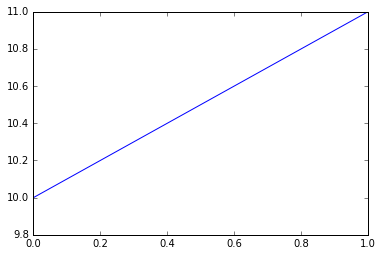

In [46]:
import matplotlib.pyplot as plt

# オブジェクト・ストレージの認証情報
# この内容は、https://console.bluemix.net/catalog/infrastructure/object-storage-group?env_id=ibm%3Ayp%3Aus-south&taxonomyNavigation=apps のサービス資格情報で置き換えます
credentials = {
  "auth_url": 
  "project": 
  "projectId": 
  "region": 
  "userId": 
  "username": 
  "password": 
  "domainId": 
  "domainName": 
  "role":
}

object_name = "testDataSet.csv"   # オブジェクト名
container_name = "SandBox"         # コンテナ



# データ生成
x = np.linspace(0,1,60)              # x データ作成
y = np.linspace(10,11,60)            # y データ作成
data_xy = np.stack((x, y), axis=-1)  # 一本の配列に変更 (x,y)の２次元配列
data_label = ["Time","Data"]         # データラベル


# CSV形式で保存
rslt,status = Write_CSV_to_ObjectStorage(credentials, data_xy, data_label, container_name, object_name)
if rslt == True:
    print "書込み成功 ", status
    
    # CSV形式データの読み取り
    result,status,Label,Data = Read_CSV_from_ObjectStorage(credentials, container_name, object_name)

    if result == True:
        print "読取り成功"
        xy = np.array(Data)     # numpy２次元配列 (CSVの列数に依存）
        # グラフ描画
        x = np.array(xy[:,[0]]) # 1列目を取り出す
        y = np.array(xy[:,[1]]) # 2列目を取り出す
        plt.plot(x,y)
        plt.show()
    
    else:    
        print "読取り失敗 ", status

else:
        print "書込み失敗 ", status